In [1]:
%matplotlib inline

In [2]:
import numpy as np
import os
import csv
import itertools

from clusim.clustering import Clustering
import clusim.sim as sim
import clusim.clugen as clugen
import clusim.clusimelement as elsim

from sklearn.cluster import AgglomerativeClustering


import matplotlib.pylab as plt

def hex2rgb(value):
    value = value.lstrip('#')
    lv = len(value)
    return tuple(int(value[i:i + lv // 3], 16)/255. for i in range(0, lv, lv // 3))

# define some colors for drawing
try:
    import seaborn as sns
    sns.set_style('white')
    red_color = sns.color_palette()[3]
    
    BiasColorDict = {}
    BiasColorDict['jaccard_index'] = sns.color_palette()[9] 
    BiasColorDict['fowlkes_mallows_index'] = sns.color_palette()[2]
    BiasColorDict['adj_rand'] = sns.color_palette()[8]
    BiasColorDict['fmeasure'] = sns.color_palette()[6]
    BiasColorDict['elmsim'] = hex2rgb('#1F1F1F')
    BiasColorDict['nmi'] = sns.color_palette()[1]
    BiasColorDict['onmi'] = sns.color_palette()[0]
    
except ImportError:
    red_color = 'r'
    
    BiasColorDict = {}
    BiasColorDict['jaccard_index'] = hex2rgb('#6BB5E6')
    BiasColorDict['fowlkes_mallows_index'] = hex2rgb('#008000')
    BiasColorDict['adj_rand'] = hex2rgb('#F1DE50')
    BiasColorDict['fmeasure'] = hex2rgb('#BF82A8')
    BiasColorDict['elmsim'] = hex2rgb('#1F1F1F')
    BiasColorDict['nmi'] = hex2rgb('#C86629')
    BiasColorDict['onmi'] = hex2rgb('#2875AE')


# wrap the Sklearn AgglomerativeClustering
def GetHierCluster(data, membership, K = 4, metric = 'correlation', linkage_method = 'average'):
    ac = AgglomerativeClustering(n_clusters=K, 
                                 affinity=metric, 
                                linkage=linkage_method)
    hierclus = Clustering()
    agg_membership = ac.fit_predict(data, membership)
    hierclus.from_membership_list(agg_membership)
    return hierclus

# Example 1
The clustering similarity measures presented here differ in how each evaluates the trade-offs between variation in three primary characteristics of clusterings: the grouping of elements into clusters, the number of clusters, and the size distribution of those clusters.  To illustrate these trade-offs, we present three simple examples a,b,c.

In [3]:
n_samples = 20 # set to 100 to fully reproduce the results from the paper

n_elements = 2**10
n_clusterfixed = 2**5


def adj_rand(c1, c2):
    # set paramter values for adjusted rand index
    return sim.adjrand_index(c1, c2, random_model = 'perm')

def elmsim(c1, c2):
    # set paramter values for element_centric similarity
    return sim.element_sim(c1, c2, alpha = 0.9)

# list of similarity measures to compare
measure_list = ['jaccard_index', 'fmeasure', 'adj_rand', 'fowlkes_mallows_index', 'nmi', 'onmi', 'elmsim']
n_measures = len(measure_list)

### Example 1a
In the first example, 1,024 elements are grouped into 32 clusters of equal size and compared against a similar clustering with a fraction of the elements randomly exchanged between the clusters, keeping the same cluster sizes.

In [4]:
n_shuffle_points = 40
percent_shuffle_values = np.linspace(0.0, 1.0, n_shuffle_points)
percent_randomize_compare = np.zeros((n_measures, n_shuffle_points, n_samples))

# loop through samples and print status every 10
for isample in range(n_samples):
    if isample % 10 == 0: print(isample)
        
    # loop through the shuffle fraction points
    for iper in range(n_shuffle_points):
        random_cluster = clugen.make_equal_clustering(n_elements, n_clusterfixed)
        random_cluster2 = clugen.shuffle_memberships(random_cluster, percent = percent_shuffle_values[iper])
        
        for imeasure in range(n_measures):
            if measure_list[imeasure] in ['adj_rand', 'elmsim']:
                percent_randomize_compare[imeasure, iper, isample] = eval(measure_list[imeasure]+'(random_cluster, random_cluster2)')
            else:
                percent_randomize_compare[imeasure, iper, isample] = eval('sim.'+measure_list[imeasure]+'(random_cluster, random_cluster2)')
        

measure_means = np.mean(percent_randomize_compare, axis = 2)
measure_stds = np.std(percent_randomize_compare, axis = 2)
print("Simulation Finished")

0
10
Simulation Finished


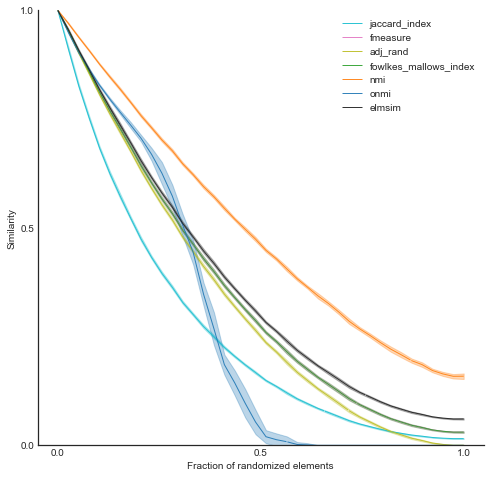

In [5]:
# plot results
fig, ax = plt.subplots(1,1, figsize = (8,8))

for imeasure in range(n_measures):
    ax.fill_between(percent_shuffle_values, measure_means[imeasure] - measure_stds[imeasure], 
                    measure_means[imeasure] + measure_stds[imeasure], 
                         color = BiasColorDict[measure_list[imeasure]], alpha = 0.3)
    line = ax.plot(percent_shuffle_values, measure_means[imeasure], color = BiasColorDict[measure_list[imeasure]],
                label = measure_list[imeasure], alpha = 0.9, lw = 1, dashes = [500,1])

ax.set_ylim([0.0, 1.0])
ax.set_xticks([0.0, 0.5, 1.0])
ax.set_yticks([0.0, 0.5, 1.0])

ax.set_xlabel('Fraction of randomized elements')
ax.set_ylabel('Similarity')

for spine in ['right', 'top']:
    ax.spines[spine].set_visible(False)

plt.legend()
plt.show()

### Example 1b
In the second example, 1,024 elements are grouped into 32 clusters of equal size and compared against a similar clustering with increasing cluster size skew-ness (measured by the entropy of the cluster size distribution). 

In [6]:
n_skew_points = 10**2 # increase to 10**4 to incrase the entropy range as in the paper
skew_step_size = 5*10**2

skewed_clusters_compare = np.zeros((n_measures + 1, n_skew_points, n_samples)) # we also need to store the cluster entropy

initial_cluster = clugen.make_equal_clustering(n_elements, n_clusterfixed)

# loop through samples and print status every 10
for isample in range(n_samples):
    if isample % 10 == 0: print(isample)
        
    # create a copy of the original clustering with all memberships randomized
    random_cluster = clugen.shuffle_memberships(initial_cluster, percent = 1.0)
    
    # loop through the fraction points
    for istep in range(n_skew_points):
        
        # record the entropy
        skewed_clusters_compare[n_measures, istep, isample] = sim.entropy(np.array(random_cluster.clu_size_seq, dtype = float)/n_elements)
        
        # perform clustering similarity measurements
        for imeasure in range(n_measures):
            if measure_list[imeasure] in ['adj_rand', 'elmsim']:
                skewed_clusters_compare[imeasure, istep, isample] = eval(measure_list[imeasure]+'(initial_cluster, random_cluster)')
            else:
                skewed_clusters_compare[imeasure, istep, isample] = eval('sim.'+measure_list[imeasure]+'(initial_cluster, random_cluster)')
        
        # now apply the Preferential Attachment Model 'skew_step_size' times
        random_cluster = clugen.shuffle_memberships_pa(random_cluster, n_steps=skew_step_size, 
                                                       constant_num_clusters=True)


print("Simulation Finished")

0
10
Simulation Finished


In [7]:
# once we have finished sampling clusterings, we need to aggregate the comparisons by cluster size entropy
n_bins = 40

def binned_index(value, bins):
    return ((value >= bins).argmin().astype(int) - 1)
binned_index = np.vectorize(binned_index, excluded=[1]) 


entropy_bins = np.linspace(skewed_clusters_compare[-1].min(), skewed_clusters_compare[-1].max(), n_bins + 1)
skewed_clusters_compare[-1] = binned_index(skewed_clusters_compare[-1], entropy_bins)

skew_measure_means = np.zeros((n_measures, n_bins))
skew_measure_stds = np.zeros((n_measures, n_bins))

for ibin in range(n_bins):
    skew_measure_means[:,ibin] = np.nanmean(skewed_clusters_compare[:-1][:, skewed_clusters_compare[-1] == ibin], axis = 1)
    skew_measure_stds[:,ibin] = np.nanstd(skewed_clusters_compare[:-1][:, skewed_clusters_compare[-1] == ibin], axis = 1)



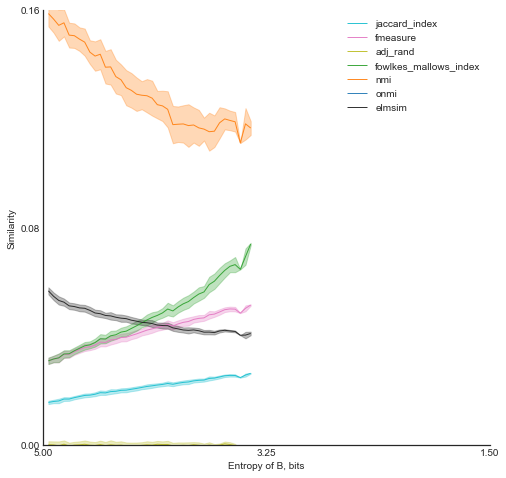

In [8]:
# plot results
fig, ax = plt.subplots(1,1, figsize = (8,8))

for imeasure in range(n_measures):
    ax.fill_between(entropy_bins[:-1], skew_measure_means[imeasure] - skew_measure_stds[imeasure], 
                    skew_measure_means[imeasure] + skew_measure_stds[imeasure], 
                         color = BiasColorDict[measure_list[imeasure]], alpha = 0.3)
    line = ax.plot(entropy_bins[:-1], skew_measure_means[imeasure], color = BiasColorDict[measure_list[imeasure]],
                label = measure_list[imeasure], alpha = 0.9, lw = 1, dashes = [500,1])

ax.set_ylim([0.0, 0.16])
ax.set_xlim([5, 1.5])
ax.set_xticks([5,3.25, 1.5])
ax.set_yticks([0.0,0.08, 0.16])

ax.set_xlabel('Entropy of B, bits')
ax.set_ylabel('Similarity')

for spine in ['right', 'top']:
    ax.spines[spine].set_visible(False)
    
plt.legend()
plt.show()

### Example 1c
In the third example, 1,024 elements are grouped into 8 clusters of equal size and compared against a similar clustering with an increasing number of equal-sized clusters.

In [9]:
n_clusterfixed = 2**3

n_cluster_points = 40
number_cluster_values = np.logspace(np.log2(n_clusterfixed), np.log2(n_elements), n_cluster_points, base = 2, dtype = int)
number_cluster_compare = np.zeros((n_measures, n_cluster_points, n_samples))

# loop through samples and print status every 10
for isample in range(n_samples):
    if isample % 10 == 0: print(isample)
        
    initial_cluster = clugen.make_equal_clustering(n_elements, n_clusterfixed)
    
    for ipoint in range(n_cluster_points):
        random_cluster = clugen.make_equal_clustering(n_elements, number_cluster_values[ipoint])
        random_cluster = clugen.shuffle_memberships(random_cluster, percent = 1.0)
        
        # perform clustering similarity measurements
        for imeasure in range(n_measures):
            if measure_list[imeasure] in ['adj_rand', 'elmsim']:
                number_cluster_compare[imeasure, ipoint, isample] = eval(measure_list[imeasure]+'(initial_cluster, random_cluster)')
            else:
                number_cluster_compare[imeasure, ipoint, isample] = eval('sim.'+measure_list[imeasure]+'(initial_cluster, random_cluster)')
        

numc_measure_mean = np.mean(number_cluster_compare, axis = 2)
numc_measure_error = np.std(number_cluster_compare, axis = 2)

print("Simulation Finished")

0
10
Simulation Finished


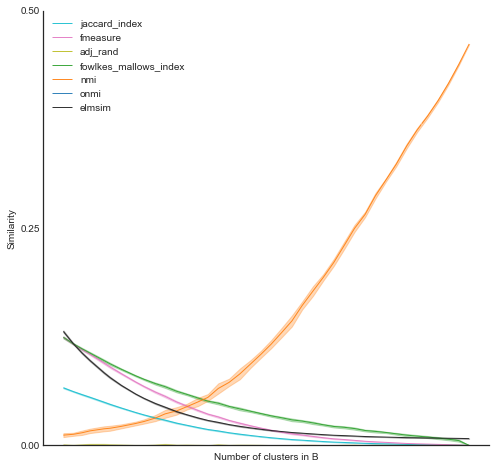

In [10]:
# plot results
fig, ax = plt.subplots(1,1, figsize = (8,8))
ax.set_xscale('log')

for imeasure in range(n_measures):
    ax.fill_between(number_cluster_values, numc_measure_mean[imeasure] - numc_measure_error[imeasure], 
                    numc_measure_mean[imeasure] + numc_measure_error[imeasure], 
                         color = BiasColorDict[measure_list[imeasure]], alpha = 0.3)
    line = ax.plot(number_cluster_values, numc_measure_mean[imeasure], color = BiasColorDict[measure_list[imeasure]],
                label = measure_list[imeasure], alpha = 0.9, lw = 1, dashes = [500,1])

ax.set_ylim([0.0, 0.5])

ax.set_xticks([])
ax.set_yticks([0.0, 0.25, 0.5])

for spine in ['right', 'top']:
    ax.spines[spine].set_visible(False)

ax.set_xlabel('Number of clusters in B')
ax.set_ylabel('Similarity')    

plt.legend()
plt.show()

# Example 2

Evaluating clustering comparisons w.r.t. random models.  We illustrate the use of random models by comparing the true classification of cancer types to a clustering derived from Agglomerative Hierarchical Clustering on gene expression data.

In [11]:
# Load the Gene Expression Data and ground truth classification

datafile = 'Data/risinger-2003_database.txt'

with open(datafile, 'r') as gefile:
    reader = csv.reader(gefile, delimiter="\t")
    d = [list(r) for r in reader]

membership = d[1]
membership.pop(0)
clusnames = {c:i for i, c in enumerate(set(membership))}
membership = [clusnames[n] for n in membership]

d = np.array(d[2:])
genetitles = d[:,0]
expressiondata = d[:,1:].astype(np.float)
K = len(clusnames)

ground_truth = Clustering()
ground_truth.from_membership_list(membership)



In [12]:
# find the Hierarchical Clustering
hierclus = GetHierCluster(expressiondata.T, membership, K)

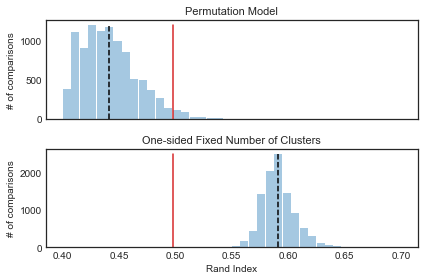

In [13]:

Nsamples = [100, 100**2]
model_list = ['perm', 'num1']
true_value = sim.rand_index(hierclus, ground_truth)

fig, ax = plt.subplots(2,1, sharex = True, figsize = (6, 4))
bins = np.linspace(0.4, 0.7, 41)

titles = ['Permutation Model', 'One-sided Fixed Number of Clusters']
for iax in range(2):
    pairwise_comparisons = sim.sample_expected_sim(hierclus, ground_truth, measure = 'rand_index', 
                                                       random_model = model_list[iax], 
                                                      n_samples = Nsamples[iax], keep_samples = True)
    
    rand_dist, bins = np.histogram(pairwise_comparisons, bins = bins)

    ax[iax].bar(0.5*(bins[:-1] + bins[1:]), rand_dist, width = 0.95*np.abs(bins[:-1] - bins[1:]), alpha = 0.4)
    
    exp_value = sim.expected_rand_index(ground_truth.n_elements, random_model = model_list[iax], 
                                         n_clusters1 = hierclus.n_clusters, 
                                         n_clusters2 = ground_truth.n_clusters, 
                                         clu_size_seq1 = hierclus.clu_size_seq, 
                                         clu_size_seq2 = ground_truth.clu_size_seq)
    
    ax[iax].plot([exp_value,exp_value], [0, rand_dist.max()], c = 'k', ls = '--')
    
    ax[iax].plot([true_value,true_value], [0, rand_dist.max()], c = sns.color_palette()[3])
    ax[iax].set_title(titles[iax], fontsize = 11)
    ax[iax].set_ylabel('# of comparisons', fontsize = 10)
    
ax[1].set_xlabel('Rand Index', fontsize = 10)

plt.tight_layout()
plt.show()